In [1]:
using DelimitedFiles, HDF5, FileIO
using Plots, Rsvg, LaTeXStrings, StatPlots
using Chemfiles, JUMD
using LinearAlgebra, Statistics
home = "/home/pbarletta/labo/18/lbp/run"
rtdos = "/home/pbarletta/labo/18/lbp/rtdos_log"
pyplot()

┌ Info: Precompiling StatPlots [60ddc479-9b66-56df-82fc-76a74619b69c]
└ @ Base loading.jl:1189
┌ Info: Recompiling stale cache file /home/pbarletta/.julia/compiled/v1.0/JUMD.ji for JUMD [top-level]
└ @ Base loading.jl:1187


Plots.PyPlotBackend()

### Lee modos, volumen original y  volúmenes NDD. Obtiene VGV

In [12]:
pdb = "4xcp"
# Leo modos
modes_4xcp, evals_4xcp = JUMD.readPtrajModes(
    joinpath(home, pdb,  "pca", string("full_modes_", pdb)))

# AAs
aa3 = convert(Int64, length(evals_4xcp))
aa = convert(Int64, aa3 / 3)

# Leo volumen de la traj
trj_vol = convert(Array{Float64, 1}, 
    readdlm(joinpath(home, pdb, "cavidad", string("vol_trj_", pdb)))[:, 3]);

# Leo volúmene del average
vol_avg_4xcp = convert(Float64, readdlm(joinpath(home, pdb,  "ndd", string("vol_avg_", pdb)))[3])

# Leo volúmenes NDD
ndd_out_4xcp = convert(Array{Float64, 1},
    readdlm(joinpath(home, pdb,  "ndd", string("out_ndd_", pdb)))[2:end, 2])

# VGV
vgv_4xcp = (ndd_out_4xcp .- vol_avg_4xcp) .* evals_4xcp
vgv_4xcp = vgv_4xcp ./ norm(vgv_4xcp);

### Obtengo proyecciones de PCA sobre trayectoria

In [14]:
dif = h5read(joinpath(rtdos, string("diff_", pdb, ".h5")), "dif")
norm_dif = mapslices(x -> x ./ norm(x), dif,  dims = 1)
nframes = size(dif)[2]

prj_1_4xcp = Array{Float64, 1}(undef, nframes)
prj_2_4xcp = Array{Float64, 1}(undef, nframes)
prj_3_4xcp = Array{Float64, 1}(undef, nframes)

for i = 1:nframes
    prj_1_4xcp[i] = dot(norm_dif[:, i], modes_4xcp[:, 1])
    prj_2_4xcp[i] = dot(norm_dif[:, i], modes_4xcp[:, 2])
    prj_3_4xcp[i] = dot(norm_dif[:, i], modes_4xcp[:, 3])
end

# Smooth
smooth_prj_1_4xcp = [ mean(prj_1_4xcp[i:i+9]) for i = 1:10:length(prj_1_4xcp)-9 ]
smooth_prj_2_4xcp = [ mean(prj_2_4xcp[i:i+9]) for i = 1:10:length(prj_2_4xcp)-9 ]
smooth_prj_3_4xcp = [ mean(prj_3_4xcp[i:i+9]) for i = 1:10:length(prj_3_4xcp)-9 ];

HDF5-DIAG: Error detected in HDF5 (1.10.0-patch1) thread 139783114222784:
  #000: ../../../src/H5F.c line 410 in H5Fis_hdf5(): unable open file
    major: File accessibilty
    minor: Not an HDF5 file
  #001: ../../../src/H5Fint.c line 529 in H5F_is_hdf5(): unable to open file
    major: Low-level I/O
    minor: Unable to initialize object
  #002: ../../../src/H5FD.c line 812 in H5FD_open(): open failed
    major: Virtual File Layer
    minor: Unable to initialize object
  #003: ../../../src/H5FDsec2.c line 348 in H5FD_sec2_open(): unable to open file: name = '/home/pbarletta/labo/18/lbp/rtdos_log/diff_4xcp.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0
    major: File accessibilty
    minor: Unable to open file


ErrorException: Cannot access file /home/pbarletta/labo/18/lbp/rtdos_log/diff_4xcp.h5

#### Leo los vectores diferencia y los normalizo
#### Obtengo las proyecciónes de vectores diferencia sobre los 1eros PCA

In [4]:
idx_vol1 = convert(Array{Int64}, readdlm(joinpath(rtdos, string(pdb, "_idx_vol1")))[:, 1])
idx_vol2 = convert(Array{Int64}, readdlm(joinpath(rtdos, string(pdb, "_idx_vol2")))[:, 1])
idx_vol3 = convert(Array{Int64}, readdlm(joinpath(rtdos, string(pdb, "_idx_vol3")))[:, 1])

# Estiro el volumen 
full_trj_vol = Array{Float64}(undef, length(trj_vol)*10)
for i = 1:length(trj_vol)
    k = (i-1) * 10 + 1
    full_trj_vol[k:k+9] =  fill(trj_vol[i], 10)
end

trj_vol1 = full_trj_vol[idx_vol1]
trj_vol2 = full_trj_vol[idx_vol2]
trj_vol3 = full_trj_vol[idx_vol3];

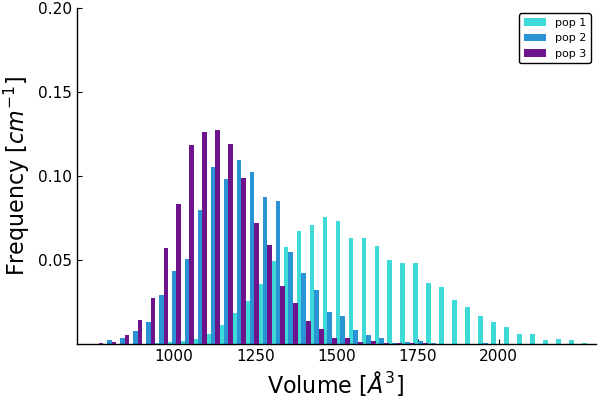

In [21]:
st = 40
bw = 28
fa = .7
bin_range = 700:st:2300
bin_vol = collect(bin_range)

# Histograma ponderado
wgh_vol = fill(1.0, length(idx_vol1))
bin_vol1_4xcp, his_vol1_4xcp = JUMD.WeightedHist(trj_vol1, bin_vol, wgh_vol, true, false)

wgh_vol = fill(1.0, length(idx_vol2))
bin_vol2_4xcp, his_vol2_4xcp = JUMD.WeightedHist(trj_vol2, bin_vol, wgh_vol, true, false)

wgh_vol = fill(1.0, length(idx_vol3))
bin_vol3_4xcp, his_vol3_4xcp = JUMD.WeightedHist(trj_vol3, bin_vol, wgh_vol, true, false)

grp = repeat(["pop 1", "pop 2", "pop 3"], inner = length(bin_vol1_4xcp))
clr = repeat([colorant"#3DDAD7", colorant"#2A93D5", colorant"#6d138b"],
    inner = length(bin_vol1_4xcp))

plt_his_vols = groupedbar(
    repeat(bin_vol1_4xcp, outer = 3), hcat(his_vol1_4xcp, his_vol2_4xcp, his_vol3_4xcp),
    group = grp, fillcolor = clr, bar_width = 45,
    xticks = 1E3:250:2E3, yticks = .05:.05:.2,
    xlims = (700, 2300), ylims = (0, .2),
    
    linecolor = false, legend = (.9, .95),
    grid = false, guidefont = font(16, "cursive"), tickfont = font(11, "cursive"),
    yaxis = L"Frequency $[cm^{-1}]$", xaxis = L"Volume $[\AA^3]$ ")

In [23]:
savefig(plt_his_vols, joinpath(rtdos, "papel", "3", string("3_VolHis_", pdb, ".svg")))

## Distancia entre extremos de ligando p/ las 3 poblaciones

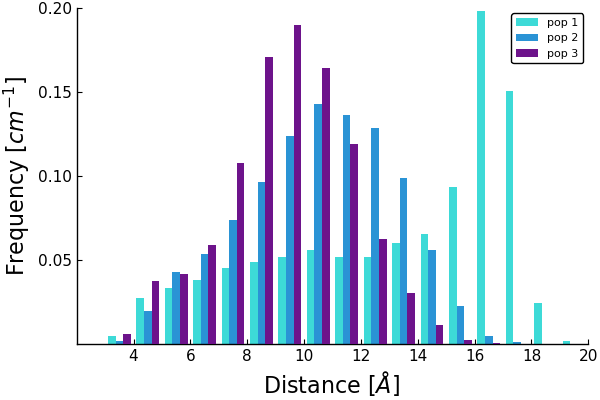

In [40]:
# Leo distancias
dis_lig_vol1 = h5read(joinpath(rtdos, string("dis_lig_", pdb, ".h5")), "vol1")
dis_lig_vol2 = h5read(joinpath(rtdos, string("dis_lig_", pdb, ".h5")), "vol2")
dis_lig_vol3 = h5read(joinpath(rtdos, string("dis_lig_", pdb, ".h5")), "vol3")

st = 1
bin_range = 2:st:20
bin_vol = collect(bin_range)

# Histograma ponderado
wgh_vol = fill(1.0, length(dis_lig_vol1))
bin_dis1_4xcp, his_dis1_4xcp = JUMD.WeightedHist(dis_lig_vol1, bin_vol, wgh_vol, true, false)

wgh_vol = fill(1.0, length(dis_lig_vol2))
bin_dis2_4xcp, his_dis2_4xcp = JUMD.WeightedHist(dis_lig_vol2, bin_vol, wgh_vol, true, false)

wgh_vol = fill(1.0, length(dis_lig_vol3))
bin_dis3_4xcp, his_dis3_4xcp = JUMD.WeightedHist(dis_lig_vol3, bin_vol, wgh_vol, true, false)

grp = repeat(["pop 1", "pop 2", "pop 3"], inner = length(bin_dis1_4xcp))
clr = repeat([colorant"#3DDAD7", colorant"#2A93D5", colorant"#6d138b"],
    inner = length(bin_dis1_4xcp))

plt_his_dis = groupedbar(
    repeat(bin_dis1_4xcp, outer = 3), hcat(his_dis1_4xcp, his_dis2_4xcp, his_dis3_4xcp),
    group = grp, fillcolor = clr,
    #bar_width = 1.5, fillalpha = .7,
    xticks = 4:2:20, yticks = .05:.05:.2,
    xlims = (2, 20), ylims = (0, .2),
    
    linecolor = false, legend = (.9, .95),
    grid = false, guidefont = font(16, "cursive"), tickfont = font(11, "cursive"),
    yaxis = L"Frequency $[cm^{-1}]$", xaxis = L"Distance $[\AA]$ ")

In [25]:
savefig(plt_his_dis, joinpath(rtdos, "papel", "5", string("5_Dis_", pdb, ".svg")))